#Leaf disease classification model

# 1.Imports

In [ ]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 GPU connection

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# main directory
train_dir = "../train images"

### 1.2 Resizing images

Images are being resized to 375 x 250 pixels, which preserves their original proportions but at the same time speeds-up learning process significantly. 

Images are saved as numpy arrays.

In [ ]:
arrays = []

for img in os.listdir(train_dir):
    image = cv2.imread(os.path.join(train_dir, img))
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    resized_image = cv2.resize(rgb_image, (375, 250))
    arrays.append(resized_image)

In [ ]:
# Saving transformed images as back-up 

data = np.save("../train_arrays.npy", np.array(arrays))

In [ ]:
# loading images and labels

data = np.load("../train_arrays.npy")
labels = np.load("../train_labels.npy")

Sample image and its label

[0 0 0 1]


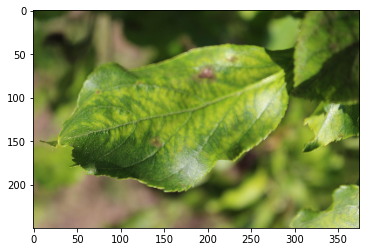

In [ ]:
plt.imshow(data[0])
print(labels[0])

### 1.3 Reformating labels to numerical values

In [ ]:
labels_num = []

for i in labels:
  if i[0] == 1:
    labels_num.append(0)
  elif i[1] == 1:
    labels_num.append(1)
  elif i[2] == 1:
    labels_num.append(2)
  elif i[3] == 1:
    labels_num.append(3)

labels_num = np.array(labels_num)     

### 1.4 Classes distribution

The distribution of classes in the dataset is uneven, i.e. class '1' consists only of 100 samples. This has to be fixed in order to maintain prediction accuracy.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


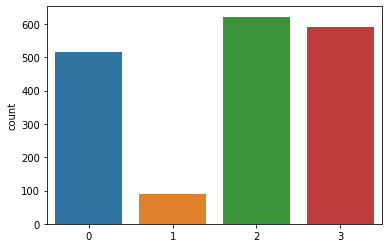

In [ ]:
sns.countplot(labels_num)

### 1.5 Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_num, test_size=0.1, random_state=88) 

In [ ]:
X_train.shape

(1638, 250, 375, 3)

# 2.Dataset oversampling

Images are being oversampled to create training dataset with balanced distrbution of all classes.

In [ ]:
ros = RandomOverSampler(random_state=88)

X_train, y_train = ros.fit_resample(X_train.reshape((-1, 250 * 375 * 3)), y_train)
X_train = X_train.reshape((-1, 250, 375, 3))
X_train.shape, y_train.shape

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


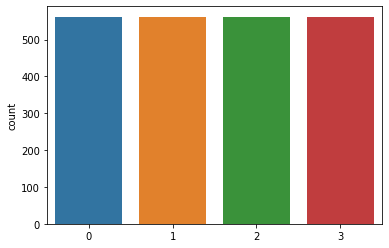

In [ ]:
sns.countplot(y_train)

# 3.Data Augumentation

Original dataset is rather small. I applied image augumentation to improve models accuracy

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
        samplewise_center = True,
        samplewise_std_normalization = True,
        rescale=1./255,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

valid_generator = test_datagen.flow(x=X_test, y=y_test, batch_size=batch_size)

# 4.Model CNN

### 4.1 Regularized dense layer

In [ ]:
RegularDense = partial(keras.layers.Dense,
                       activation="elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01))

### 4.2 Model architecture

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[250,375,3]))
model.add(keras.layers.ZeroPadding2D(padding=3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(7,7), data_format='channels_last'))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(7,7), data_format='channels_last'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(5,5), data_format='channels_last', padding="same"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(5,5), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(filters=512, kernel_size=(1,1), data_format='channels_last', padding="same"))
model.add(keras.layers.Conv2D(filters=512, kernel_size=(1,1), data_format='channels_last', padding="same"))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(160))
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(80))
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(80))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(40))
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(20))
model.add(keras.layers.BatchNormalization())
model.add(RegularDense(10))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 256, 381, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 250, 375, 32)      4736      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 244, 369, 32)      50208     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 122, 184, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 122, 184, 64)      51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 122, 184, 64)      102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 92, 64)       

### 4.3 Model compilation

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer= Adam(),
             metrics=["accuracy"])

### 4.4 Custom learning rate

Learning rate is increasing for first 10 epochs, stays at its maximal level for another 10 epochs and starts to drop exponentially. 

In [ ]:
start = 0.0001
min = 0.00001
max = 0.001
rampup_epochs = 10
sustain_epochs = 10
decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max - start)/rampup_epochs * epoch + start
  elif epoch < rampup_epochs + sustain_epochs:
    return max
  else:
    return min
    
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

### 4.5 Training

In [ ]:
history = model.fit(train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=40,
        validation_data=valid_generator,
        validation_steps=len(X_test) // batch_size,
        callbacks=[lr])

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))